In [1]:
#Imports
import matplotlib.pyplot as plt
import seaborn
import numpy
import pandas
import math

import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from lion_pytorch import Lion

In [2]:
#Training Hyperparameters: TODO: different per optimizer, find via grid search for example
EPOCHS = 6
TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = 1000
LEARNING_RATE = 0.01
MOMENTUM = 0.5

#Seeding for Deterministic and reproducible results
torch.backends.cudnn.enabled = False
torch.backends.cudnn.deterministic = True
torch.manual_seed(8)

#MNIST specific constants
MNIST_MEAN = 0.1307
MNIST_STD = 0.3081

TRAINING_SET_SIZE = 60_000
TEST_SET_SIZE = 10_000
TRAINING_BATCHES = math.ceil(TRAINING_SET_SIZE / TRAIN_BATCH_SIZE)
TEST_BATCHES = math.ceil(TEST_SET_SIZE / TEST_BATCH_SIZE)

In [3]:
#Load data into training and test set
mnist_transformer = transforms.Compose([transforms.ToTensor(),transforms.Normalize((MNIST_MEAN,), (MNIST_STD,))])
training_set = torch.utils.data.DataLoader(
  datasets.MNIST(root='./data/', train=True, download=True, transform=mnist_transformer), batch_size=TRAIN_BATCH_SIZE, shuffle=True)

test_set = torch.utils.data.DataLoader(
  datasets.MNIST(root='./data', train=False, download=True, transform=mnist_transformer), batch_size=TEST_BATCH_SIZE, shuffle=True)

In [4]:
#Neural network inspiring by https://nextjournal.com/gkoehler/pytorch-mnist
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [5]:
#Train a given model, stores model under given name
'''
plot_granularity: after how many batches should we store a loss for representing in the plot
'''
def train_model(model, optimizer, criterion, store_name, training_set, epochs, plot_granularity):
    model.train()
    loss_list = []
    trained_examples = []
    accuracy_list = []
    for epoch in range(0, epochs):
        #one training iteration
        loss_total = 0
        loss_count = 0
        print(f"Epoch: {epoch+1}|{epochs}")
        for batch, (data, label) in enumerate(training_set):
            optimizer.zero_grad()
            pred = model(data)
            loss = criterion(pred, label)
            loss_total += loss.item()
            loss_count += 1
            loss.backward()
            optimizer.step()
            if batch % plot_granularity == 0:
                #print(f"Epoch {epoch}: Loss: {loss.item()}")
                #append the average of all losses since the last recorded one
                loss_average = loss_total / loss_count
                loss_list.append(loss_average)
                #reset variables once we record
                loss_total = 0
                loss_count = 0
                trained_examples.append(TRAIN_BATCH_SIZE*batch + epoch*TRAINING_SET_SIZE)

    torch.save(model.state_dict(), "./models/" + store_name)
    torch.save(optimizer.state_dict(), "./optimizers/" + store_name)

    return loss_list, accuracy_list, trained_examples, store_name

In [6]:
def test_model(model, criterion, test_set, name):
    model.eval()
    total_loss = 0
    total_correct = 0
    with torch.no_grad():
        for data,label in test_set:
            preds = model(data)
            loss = criterion(preds, label)
            total_loss += loss
            pred = preds.data.max(1, keepdim=True)[1]
            correct = pred.eq(label.data.view_as(pred)).sum()
            total_correct += correct
    
    average_loss = total_loss / TEST_SET_SIZE
    accuracy = total_correct / TEST_SET_SIZE

    return average_loss, accuracy, name

In [7]:
train_plot_info = []
test_plot_info = []
PLOT_GRANULARITY = 50

In [8]:
#Train using SGD with momentum
model_sgdm = NN()
sgdm = optim.SGD(model_sgdm.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
criterion_sgdm = nn.NLLLoss()

train_plot_info.append(train_model(model_sgdm, sgdm, criterion_sgdm, "SGD with Momentum", training_set, EPOCHS, PLOT_GRANULARITY))
test_plot_info.append(test_model(model_sgdm, criterion_sgdm, test_set, "SGD with Momentum"))

Epoch: 1|6
Epoch: 2|6
Epoch: 3|6
Epoch: 4|6
Epoch: 5|6
Epoch: 6|6


In [9]:
#Train using RMSProp
model_rms = NN()
rms = optim.RMSprop(model_rms.parameters(), lr=LEARNING_RATE, momentum=0)
criterion_rms = nn.NLLLoss()
train_plot_info.append(train_model(model_rms, rms, criterion_rms, "RMSProp", training_set, EPOCHS, PLOT_GRANULARITY))
test_plot_info.append(test_model(model_rms, criterion_rms, test_set, "RMSProp"))

Epoch: 1|6
Epoch: 2|6
Epoch: 3|6
Epoch: 4|6
Epoch: 5|6
Epoch: 6|6


In [10]:
#Train using Lion
model_lion = NN()
lion = Lion(model_lion.parameters(), lr=1e-4, weight_decay=1e-2)
criterion_lion = nn.NLLLoss()

train_plot_info.append(train_model(model_lion, lion, criterion_lion, "Lion", training_set, EPOCHS, PLOT_GRANULARITY))
test_plot_info.append(test_model(model_lion, criterion_lion, test_set, "Lion"))

Epoch: 1|6
Epoch: 2|6
Epoch: 3|6
Epoch: 4|6
Epoch: 5|6
Epoch: 6|6


In [11]:
#Train using SGD
model_sgd = NN()
sgd = optim.SGD(model_sgd.parameters(), lr=LEARNING_RATE, momentum=0)
criterion_sgd = nn.NLLLoss()

train_plot_info.append(train_model(model_sgd, sgd, criterion_sgd, "SGD", training_set, EPOCHS, PLOT_GRANULARITY))
test_plot_info.append(test_model(model_sgd, criterion_sgd, test_set, "SGD"))

Epoch: 1|6
Epoch: 2|6
Epoch: 3|6
Epoch: 4|6
Epoch: 5|6
Epoch: 6|6


In [12]:
#Train using Adam
model_adam = NN()
adam = optim.Adam(model_adam.parameters(), lr=LEARNING_RATE)
criterion_adam = nn.NLLLoss()

train_plot_info.append(train_model(model_adam, adam, criterion_adam, "Adam", training_set, EPOCHS, PLOT_GRANULARITY))
test_plot_info.append(test_model(model_adam, criterion_adam, test_set, "Adam"))

Epoch: 1|6
Epoch: 2|6
Epoch: 3|6
Epoch: 4|6
Epoch: 5|6
Epoch: 6|6


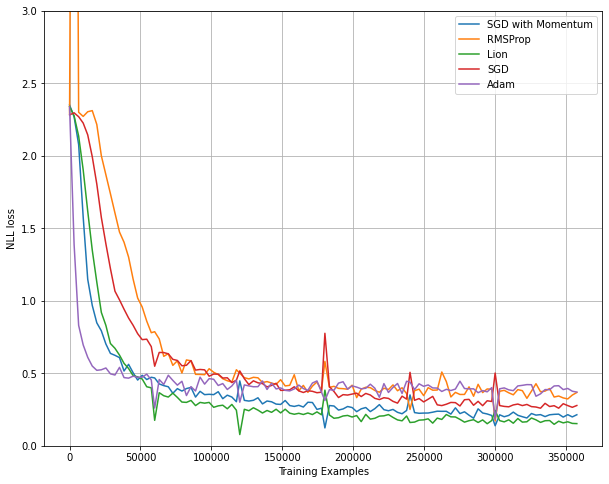

In [13]:
fig, axs = plt.subplots(figsize=(10,8))
[plt.plot(c,a) for (a,_,c,_) in train_plot_info]
axs.legend([d for (a,b,c,d) in train_plot_info], loc='upper right')
plt.xlabel('Training Examples')
plt.ylabel('NLL loss')
plt.ylim([0,3])
plt.grid()
plt.show()

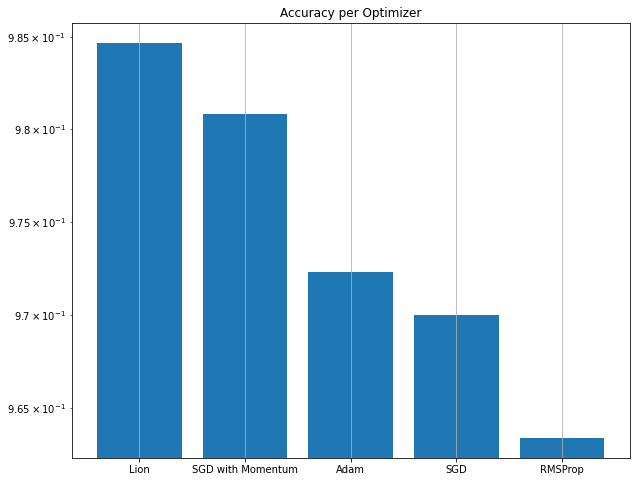

In [20]:
fig, axs = plt.subplots(figsize=(10,8))
acc_pairs = [(c,b) for (a,b,c) in test_plot_info]
sorted_acc_pairs = sorted(acc_pairs,key=lambda t: t[1], reverse=True)
sorted_names = [a[0] for a in sorted_acc_pairs]
sorted_acc = [a[1] for a in sorted_acc_pairs]
axs.bar(sorted_names, sorted_acc, log=True)
plt.title("Accuracy per Optimizer")
plt.grid()
plt.show()

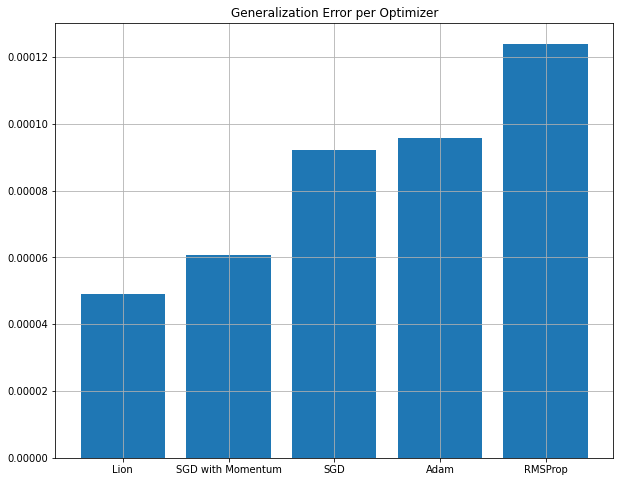

In [19]:
fig, axs = plt.subplots(figsize=(10,8))
loss_pairs = [(c,a) for (a,b,c) in test_plot_info]
sorted_loss_pairs = sorted(loss_pairs,key=lambda t: t[1], reverse=False)
sorted_names = [a[0] for a in sorted_loss_pairs]
sorted_loss = [a[1] for a in sorted_loss_pairs]
axs.bar(sorted_names, sorted_loss)
plt.title("Generalization Error per Optimizer")
plt.grid()
plt.show()

In [16]:
#TODO: Can also plot execution times (including hardware information), in case there are differences